<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: Numerical Solution of the Scalar Wave Equation, in Curvilinear Coordinates

## Author: Zach Etienne
### Formatting improvements courtesy Brandon Clark

## This module solves the scalar wave equation in *spherical coordinates* (though other coordinates, including Cartesian, may be chosen).

**Notebook Status:** <font color ="green"><b> Validated </b></font>

**Validation Notes:** This module has been validated to converge at the expected order to the exact solution (see [plot](#convergence) at bottom).

### NRPy+ Source Code for this module: 
* [ScalarWave/ScalarWaveCurvilinear_RHSs.py](../edit/ScalarWave/ScalarWaveCurvilinear_RHSs.py) [\[**tutorial**\]](Tutorial-ScalarWaveCurvilinear.ipynb) Generates the right-hand side for the Scalar Wave Equation in curvilinear coordinates
* [ScalarWave/InitialData.py](../edit/ScalarWave/InitialData.py) [\[**tutorial**\]](Tutorial-ScalarWave.ipynb) Generating C code for either plane wave or spherical Gaussian initial data for the scalar wave equation 

## Introduction:
As outlined in the [previous NRPy+ tutorial notebook](Tutorial-ScalarWaveCurvilinear.ipynb), we first use NRPy+ to generate initial data for the scalar wave equation, and then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on the [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4).

The entire algorithm is outlined below, with NRPy+-based components highlighted in <font color='green'>green</font>.

1. Allocate memory for gridfunctions, including temporary storage for the RK4 time integration.
1. <font color='green'>Set gridfunction values to initial data.</font>
1. Evolve the system forward in time using RK4 time integration. At each RK4 substep, do the following:
    1. <font color='green'>Evaluate scalar wave RHS expressions.</font>
    1. Apply boundary conditions.
1. At the end of each iteration in time, output the relative error between numerical and exact solutions.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#writec): Generate C code to solve the scalar wave equation in curvilinear coordinates
    1. [Step 1.a](#id_rhss): C code generation: Initial data and scalar wave right-hand-sides
    1. [Step 1.b](#OuterBoundaryConditions): C code generation: Boundary condition driver
    1. [Step 1.c](#cparams_rfm_and_domainsize): Generate Cparameters files; set reference metric parameters, including `domain_size`
    1. [Step 1.d](#cfl): C code generation: Finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep
1. [Step 2](#mainc): The C code `main()` function for `ScalarWaveCurvilinear_Playground`
1. [Step 3](#compileexec): Compile generated C codes & solve the scalar wave equation
1. [Step 4](#convergence): Code validation: Plot the numerical error, and confirm that it converges to zero at expected rate with increasing numerical resolution (sampling)
1. [Step 5](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='writec'></a>

# Step 1: Using NRPy+ to generate necessary C code to solve the scalar wave equation in curvilinear, singular coordinates \[Back to [top](#toc)\]
$$\label{writec}$$

<a id='id_rhss'></a>

## Step 1.a: C code generation: Initial data and scalar wave RHSs \[Back to [top](#toc)\]
$$\label{id_rhss}$$


We choose simple plane wave initial data, which is documented in the [Cartesian scalar wave module](Tutorial-ScalarWave.ipynb). Specifically, we implement monochromatic (single-wavelength) wave traveling in the $\hat{k}$ direction with speed $c$
$$u(\vec{x},t) = f(\hat{k}\cdot\vec{x} - c t),$$
where $\hat{k}$ is a unit vector.

The scalar wave RHSs in curvilinear coordinates (documented [in the previous module](Tutorial-ScalarWaveCurvilinear.ipynb)) are simply the right-hand sides of the scalar wave equation written in curvilinear coordinates
\begin{align}
\partial_t u &= v \\
\partial_t v &= c^2 \left(\hat{g}^{ij} \partial_{i} \partial_{j} u - \hat{\Gamma}^i \partial_i u\right),
\end{align}
where $\hat{g}^{ij}$ is the inverse reference 3-metric (i.e., the metric corresponding to the underlying coordinate system we choose$-$spherical coordinates in our example below), and $\hat{\Gamma}^i$ is the contracted Christoffel symbol $\hat{\Gamma}^\tau = \hat{g}^{\mu\nu} \hat{\Gamma}^\tau_{\mu\nu}$.

Below we generate 
+ the initial data by calling `InitialData(Type="PlaneWave")` inside the NRPy+ [ScalarWave/InitialData.py](../edit/ScalarWave/InitialData.py) module (documented in [this NRPy+ Jupyter notebook](Tutorial-ScalarWave.ipynb)), and 
+ the RHS expressions by calling `ScalarWaveCurvilinear_RHSs()` inside the NRPy+ [ScalarWave/ScalarWaveCurvilinear_RHSs.py](../edit/ScalarWave/ScalarWaveCurvilinear_RHSs.py) module (documented in [this NRPy+ Jupyter notebook](Tutorial-ScalarWaveCurvilinear.ipynb)).

In [1]:
# Step P1: Import needed NRPy+ core modules:
from outputC import lhrh, add_to_Cfunction_dict  # NRPy+: Core C code output module
import finite_difference as fin       # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par        # NRPy+: Parameter interface
import grid as gri                    # NRPy+: Functions having to do with numerical grids
import reference_metric as rfm        # NRPy+: Reference metric support
import cmdline_helper as cmd          # NRPy+: Multi-platform Python command-line interface
import shutil, os, sys                # Standard Python modules for multiplatform OS-level functions

# Step P2: Create C code output directory:
Ccodesrootdir = os.path.join("ScalarWaveCurvilinear_Playground_Ccodes")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
shutil.rmtree(Ccodesrootdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesrootdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesrootdir, "output")
cmd.mkdir(outdir)

# Step P4: Enable/disable SIMD. If enabled, code should run ~2x faster on most CPUs.
enable_SIMD = True

# Step P5: Enable reference metric precomputation.
enable_rfm_precompute = True
if enable_rfm_precompute:
    par.set_parval_from_str("reference_metric::rfm_precompute_to_Cfunctions_and_NRPy_basic_defines", "True")
else:
    par.set_parval_from_str("reference_metric::rfm_precompute_to_Cfunctions_and_NRPy_basic_defines", "False")

if enable_SIMD and not enable_rfm_precompute:
    print("ERROR: SIMD does not currently handle transcendental functions,\n")
    print("       like those found in rfmstruct (rfm_precompute).\n")
    print("       Therefore, enable_SIMD==True and enable_rfm_precompute==False\n")
    print("       is not supported.\n")
    sys.exit(1)

# Step P6: Enable "FD functions". In other words, all finite-difference stencils
#         will be output as inlined static functions. This is essential for
#         compiling highly complex FD kernels with using certain versions of GCC;
#         GCC 10-ish will choke on BSSN FD kernels at high FD order, sometimes
#         taking *hours* to compile. Unaffected GCC versions compile these kernels
#         in seconds. FD functions do not slow the code performance, but do add
#         another header file to the C source tree.
# With gcc 7.5.0, enable_FD_functions=True decreases performance by 10%
enable_FD_functions = False

# Step 1: Set some core parameters, including CoordSystem, boundary condition,
#                                             MoL, timestepping algorithm, FD order,
#                                             floating point precision, and CFL factor:

# Step 1.a: Set the coordinate system for the numerical grid
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
#              SymTP, SinhSymTP
CoordSystem     = "SinhSpherical"
par.set_parval_from_str("reference_metric::CoordSystem", CoordSystem)
rfm.reference_metric()

# Step 1.c: Set defaults for Coordinate system parameters.
#           These are perhaps the most commonly adjusted parameters,
#           so we enable modifications at this high level.

# domain_size sets the default value for:
#   * Spherical's params.RMAX
#   * SinhSpherical*'s params.AMAX
#   * Cartesians*'s -params.{x,y,z}min & .{x,y,z}max
#   * Cylindrical's -params.ZMIN & .{Z,RHO}MAX
#   * SinhCylindrical's params.AMPL{RHO,Z}
#   * *SymTP's params.AMAX
domain_size     = 10.0 # Needed for all coordinate systems.

# sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.4 # If Sinh* coordinates chosen

# sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05# If Sinh*v2 coordinates chosen

# SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = 1.0 # If SymTP chosen

# Step 1.d: Set the order of spatial and temporal derivatives;
#           the core data type, and the CFL factor.
# RK_method choices include: Euler, "RK2 Heun", "RK2 MP", "RK2 Ralston", RK3, "RK3 Heun", "RK3 Ralston",
#              SSPRK3, RK4, DP5, DP5alt, CK5, DP6, L6, DP8
RK_method = "RK4"
FD_order  = 4        # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
REAL      = "double" # Best to use double here.
CFL_FACTOR= 1.0
outer_bc_type = "RADIATION_OUTER_BCS"  # can be EXTRAPOLATION_OUTER_BCS or RADIATION_OUTER_BCS
radiation_BC_FD_order = 2

In [2]:
# Step 2: Import the ScalarWave.InitialData module.
#         This command only declares ScalarWave initial data
#         parameters and the InitialData() function.
import ScalarWave.InitialData as swid

# Step 3: Import ScalarWave_RHSs module.
#         This command only declares ScalarWave RHS parameters
#         and the ScalarWave_RHSs function (called later)
import ScalarWave.ScalarWaveCurvilinear_RHSs as swrhs

# Step 4: Call the InitialData() function to set up initial data.
#         Options include:
#    "PlaneWave": monochromatic (single frequency/wavelength) plane wave
#    "SphericalGaussian": spherically symmetric Gaussian, with default stdev=3
swid.InitialData(CoordSystem=CoordSystem, WaveType="SphericalGaussian")

# Step 5: Set the finite differencing order to FD_order (set above).
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)

# Step 6: Generate SymPy symbolic expressions for
#         uu_rhs and vv_rhs; the ScalarWave RHSs.
#         This function also declares the uu and vv
#         gridfunctions, which need to be declared
#         to output even the initial data to C file.
# First get into the enable_rfm_precompute environment, if enable_rfm_precompute==True
if enable_rfm_precompute:
    cmd.mkdir(os.path.join(Ccodesrootdir, "rfm_files/"))
    par.set_parval_from_str("reference_metric::enable_rfm_precompute", "True")
    par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir", os.path.join(Ccodesrootdir, "rfm_files/"))

swrhs.ScalarWaveCurvilinear_RHSs()
# Step 6.a: Now that we are finished with all the rfm hatted
#           quantities, let's restore them to their closed-
#           form expressions.
if enable_rfm_precompute:
    par.set_parval_from_str("reference_metric::enable_rfm_precompute", "False") # Reset to False to disable rfm_precompute.
rfm.ref_metric__hatted_quantities()

# Step 7: Copy SIMD/SIMD_intrinsics.h to $Ccodesrootdir/SIMD/SIMD_intrinsics.h
if enable_SIMD:
    cmd.mkdir(os.path.join(Ccodesrootdir,"SIMD"))
    shutil.copy(os.path.join("SIMD/")+"SIMD_intrinsics.h",os.path.join(Ccodesrootdir,"SIMD/"))

# Step 8: Set enable "FD functions" parameter. See above for details.
par.set_parval_from_str("finite_difference::enable_FD_functions", enable_FD_functions)

# Step 9: If enable_SIMD, then copy SIMD/SIMD_intrinsics.h to $Ccodesrootdir/SIMD/SIMD_intrinsics.h
if enable_SIMD:
    shutil.copy(os.path.join("SIMD", "SIMD_intrinsics.h"), os.path.join(Ccodesrootdir, "SIMD"))

<a id='mol'></a>

## Step 1.b: Generate Method of Lines timestepping code \[Back to [top](#toc)\]
$$\label{mol}$$

The Method of Lines algorithm is described in detail in the [**NRPy+ tutorial notebook on Method of Lines algorithm**](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).

In [3]:
# Step 10: Generate Runge-Kutta-based (RK-based) timestepping code.
#       As described above the Table of Contents, this is a 2-step process:
#       1.b.A: Evaluate RHSs (RHS_string)
#       1.b.B: Apply boundary conditions (post_RHS_string, pt 1)
import MoLtimestepping.MoL as MoL
# from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
# RK_order  = Butcher_dict[RK_method][1]
RHS_string = "rhs_eval(params, rfmstruct, RK_INPUT_GFS, RK_OUTPUT_GFS);"
if not enable_rfm_precompute:
    RHS_string = RHS_string.replace("rfmstruct", "xx")
RHS_string += """
if(params->outer_bc_type == RADIATION_OUTER_BCS)
  apply_bcs_outerradiation_and_inner(params, bcstruct, griddata->xx,
                                     gridfunctions_wavespeed,gridfunctions_f_infinity,
                                     RK_INPUT_GFS, RK_OUTPUT_GFS);"""

# Extrapolation BCs are applied to the evolved gridfunctions themselves after the MoL update
post_RHS_string = """if(params->outer_bc_type == EXTRAPOLATION_OUTER_BCS)
  apply_bcs_outerextrap_and_inner(params, bcstruct, RK_OUTPUT_GFS);"""

MoL.register_C_functions_and_NRPy_basic_defines(RK_method,
        RHS_string=RHS_string, post_RHS_string=post_RHS_string,
        enable_rfm=enable_rfm_precompute, enable_curviBCs=True, enable_SIMD=False)

In [4]:
def add_to_Cfunction_dict_exact_solution_single_point():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    desc = "Exact solution at a single point. params.time==0 corresponds to the initial data."
    c_type = "void"
    name = "exact_solution_single_point"
    params = """const paramstruct *restrict params,
                const REAL xx0, const REAL xx1, const REAL xx2,
                REAL *uu_exact, REAL *vv_exact"""
    body = fin.FD_outputC("returnstring",[lhrh(lhs="*uu_exact",rhs=swid.uu_ID),
                                          lhrh(lhs="*vv_exact",rhs=swid.vv_ID)],
                          params="includebraces=False,preindent=1,outCverbose=False")
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."))
# add_to_Cfunction_dict_exact_solution_single_point()
# from outputC import outC_function_dict
# print(outC_function_dict["exact_solution_single_point"])
# sys.exit(1)

In [5]:
def add_to_Cfunction_dict_exact_solution_all_points():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    desc = "Exact solution at all points. params.time==0 corresponds to the initial data."
    c_type = "void"
    name = "exact_solution_all_points"
    params = "const paramstruct *restrict params,REAL *restrict xx[3], REAL *restrict in_gfs"
    body = """exact_solution_single_point(params, xx0, xx1, xx2,
           &in_gfs[IDX4S(UUGF,i0,i1,i2)], &in_gfs[IDX4S(VVGF,i0,i1,i2)]);"""
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), loopopts = "AllPoints,Read_xxs")

In [6]:
def add_to_Cfunction_dict_rhs_eval():
    desc="Evaluate the scalar wave RHSs"
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    if enable_FD_functions:
        includes += ["finite_difference_functions.h"]
    if enable_SIMD:
        includes += ["SIMD/SIMD_intrinsics.h"]
    c_type = "void"
    name = "rhs_eval"
    params   ="const paramstruct *restrict params, "
    if enable_rfm_precompute:
        params += "const rfm_struct *restrict rfmstruct, "
    else:
        params += "REAL *xx[3], "
    params += "const REAL *restrict in_gfs, REAL *restrict rhs_gfs"
    body = fin.FD_outputC("returnstring",[lhrh(lhs=gri.gfaccess("rhs_gfs","uu"),rhs=swrhs.uu_rhs),
                                          lhrh(lhs=gri.gfaccess("rhs_gfs","vv"),rhs=swrhs.vv_rhs)],
                          params="enable_SIMD="+str(enable_SIMD))
    loopopts = "InteriorPoints"
    if enable_SIMD:
        loopopts += ",enable_SIMD"
    if enable_rfm_precompute:
        loopopts += ",enable_rfm_precompute"
    else:
        loopopts += ",Read_xxs"
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), loopopts = loopopts)

<a id='OuterBoundaryConditions'></a>

## Step 1.b: Output needed C code for boundary condition driver \[Back to [top](#toc)\]
$$\label{OuterBoundaryConditions}$$

In [7]:
import CurviBoundaryConditions.CurviBoundaryConditions as CBC
CBC.CurviBoundaryConditions_register_NRPy_basic_defines()
CBC.CurviBoundaryConditions_register_C_functions(radiation_BC_FD_order=radiation_BC_FD_order)

Evolved gridfunction "uu" has parity type 0.
Evolved gridfunction "vv" has parity type 0.


<a id='cparams_rfm_and_domainsize'></a>

## Step 1.c: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

Here we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above

In [8]:
# Step 1.c.i: Set free_parameters.h
outstr = r"""
// Free parameters related to physical system:
params.time = 0.0; // Initial simulation time corresponds to exact solution at time=0.
params.wavespeed = 1.0;

// Free parameters related to numerical timestep:
REAL CFL_FACTOR = """+str(CFL_FACTOR)+";\n"

# Append to $Ccodesrootdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above.
outstr += rfm.out_default_free_parameters_for_rfm("returnstring",
                                                  domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)
with open(os.path.join(Ccodesrootdir,"free_parameters.h"),"w") as file:
    file.write(outstr.replace("params.", "griddata.params."))

<a id='cfl'></a>

## Step 1.d: Output needed C code for finding the minimum proper distance between grid points, needed for [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673)-limited timestep \[Back to [top](#toc)\]
$$\label{cfl}$$

In order for our explicit-timestepping numerical solution to the scalar wave equation to be stable, it must satisfy the [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673) condition:
$$
\Delta t \le \frac{\min(ds_i)}{c},
$$
where $c$ is the wavespeed, and
$$ds_i = h_i \Delta x^i$$ 
is the proper distance between neighboring gridpoints in the $i$th direction (in 3D, there are 3 directions), $h_i$ is the $i$th reference metric scale factor, and $\Delta x^i$ is the uniform grid spacing in the $i$th direction:

In [9]:
# Generate & register C function set_Nxx_dxx_invdx_params__and__xx()
# Generate & register C function xx_to_Cart() for
#               (the mapping from xx->Cartesian) for the chosen
#               CoordSystem:
# Generate & register the find_timestep() function
rfm.register_C_functions(enable_rfm_precompute=enable_rfm_precompute)
rfm.register_NRPy_basic_defines(enable_rfm_precompute=enable_rfm_precompute)

<a id='mainc'></a>

# Step 2: The C code `main()` function for `ScalarWaveCurvilinear_Playground` \[Back to [top](#toc)\]
$$\label{mainc}$$

Just as in [the start-to-finish, solving the scalar wave equation in Cartesian coordinates module](Tutorial-Start_to_Finish-ScalarWave.ipynb), we will implement the scalar wave equation via the Method of Lines. As discussed above, the critical differences between this code and the Cartesian version are as follows:
1. The CFL-constrained timestep depends on the proper distance between neighboring gridpoints
1. The boundary conditions must account for the fact that ghost zone points lying in the domain exterior can map either to the interior of the domain, or lie on the outer boundary. In the former case, we simply copy the data from the interior. In the latter case, we apply the usual outer boundary conditions.
1. The numerical grids must be staggered to avoid direct evaluation of the equations on coordinate singularities.

In [10]:
def add_to_Cfunction_dict_main__ScalarWaveCurvilinear_Playground():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    desc = """// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Write test data to gridfunctions
// Step 2: Overwrite all data in ghost zones with NaNs
// Step 3: Apply curvilinear boundary conditions
// Step 4: Print gridfunction data after curvilinear boundary conditions have been applied
// Step 5: Free all allocated memory
"""
    c_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"
    body = r"""  griddata_struct griddata;
  set_Cparameters_to_default(&griddata.params);
  griddata.params.outer_bc_type = """+outer_bc_type+r""";

  // Step 0a: Read command-line input, error out if nonconformant
  if(argc != 4 || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < NGHOSTS) {
    printf("Error: Expected one command-line argument: ./ScalarWaveCurvilinear_Playground Nx0 Nx1 Nx2,\n");
    printf("where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
    printf("Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
    exit(1);
  }
  // Step 0b: Set up numerical grid structure, first in space...
  const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
  if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
    printf("Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
    printf("       For example, in case of angular directions, proper symmetry zones will not exist.\n");
    exit(1);
  }

  // Step 0c: Set free parameters, overwriting Cparameters defaults
  //          by hand or with command-line input, as desired.
#include "free_parameters.h"

  // Step 0d: Uniform coordinate grids are stored to *xx[3]
  // Step 0d.i: Set bcstruct
  {
    int EigenCoord;
    EigenCoord = 1;
    // Step 0d.ii: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //             params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //             chosen Eigen-CoordSystem.
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &griddata.params, griddata.xx);
    // Step 0e: Find ghostzone mappings; set up bcstruct
    bcstruct_set_up(&griddata.params, griddata.xx, &griddata.bcstruct);
    // Step 0e.i: Free allocated space for xx[][] array
    for(int i=0;i<3;i++) free(griddata.xx[i]);

    // Step 0f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //          chosen (non-Eigen) CoordSystem.
    EigenCoord = 0;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &griddata.params, griddata.xx);
  }

  // Step 0g: Time coordinate parameters
  griddata.params.t_final =  0.7*domain_size; /* Final time is set so that at t=t_final,
                                               * data at the origin have not been corrupted
                                               * by the approximate outer boundary condition */

  // Step 0h: Set timestep based on smallest proper distance between gridpoints and CFL factor
  griddata.params.dt = find_timestep(&griddata.params, griddata.xx, CFL_FACTOR);
  // Ntot = N_outputs * output_every_N -> output_every_N = Ntot/N_outputs; set N_outputs=800
  int output_every_N = (int)((griddata.params.t_final/griddata.params.dt + 0.5) / 800.0);
  if(output_every_N == 0) output_every_N = 1;

  // Step 0i: Error out if the number of auxiliary gridfunctions outnumber evolved gridfunctions.
  //              This is a limitation of the RK method. You are always welcome to declare & allocate
  //              additional gridfunctions by hand.
  if(NUM_AUX_GFS > NUM_EVOL_GFS) {
    printf("Error: NUM_AUX_GFS > NUM_EVOL_GFS. Either reduce the number of auxiliary gridfunctions,\n");
    printf("       or allocate (malloc) by hand storage for *diagnostic_output_gfs. \n");
    exit(1);
  }

  // Step 0j: Declare struct for gridfunctions and allocate memory for y_n_gfs gridfunctions
  MoL_malloc_y_n_gfs(&griddata.params, &griddata.gridfuncs);
"""
    if enable_rfm_precompute:
        body += """
  // Step 0k: Set up precomputed reference metric arrays
  // Step 0k.i: Allocate space for precomputed reference metric arrays.
  rfm_struct rfmstruct;
  rfm_precompute_rfmstruct_malloc(&griddata.params, &griddata.rfmstruct);

  // Step 0k.ii: Define precomputed reference metric arrays.
  rfm_precompute_rfmstruct_define(&griddata.params, griddata.xx, &griddata.rfmstruct);\n"""
    body += r"""
  // Step 0.l: Set up initial data to be exact solution at time=0:
  griddata.params.time = 0.0; griddata.params.n_0 = 0;
  exact_solution_all_points(&griddata.params, griddata.xx, griddata.gridfuncs.y_n_gfs);

  // Step 0.m: Allocate memory for non y_n_gfs. We do this here to free up
  //         memory for setting up initial data (for cases in which initial
  //         data setup is memory intensive.)
  MoL_malloc_non_y_n_gfs(&griddata.params, &griddata.gridfuncs);

  while(griddata.params.time < griddata.params.t_final)
    { // Main loop to progress forward in time.

    // Step 1: Diagnostics/code validation: Compute log of L2 norm of difference
    //         between numerical and exact solutions:
    //   log_L2_Norm = log10( sqrt[Integral( [numerical - exact]^2 * dV)] ),
    //         where integral is within 30% of the grid outer boundary (domain_size)
    if(griddata.params.n%output_every_N == 0) {
      REAL integral = 0.0;
      REAL numpts   = 0.0;
      const int Nxx_plus_2NGHOSTS0 = griddata.params.Nxx_plus_2NGHOSTS0;
      const int Nxx_plus_2NGHOSTS1 = griddata.params.Nxx_plus_2NGHOSTS1;
      const int Nxx_plus_2NGHOSTS2 = griddata.params.Nxx_plus_2NGHOSTS2;
#pragma omp parallel for reduction(+:integral,numpts)
      LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS,
                  NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS,
                  NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {
        REAL xCart[3]; xx_to_Cart(&griddata.params,griddata.xx,i0,i1,i2, xCart);
        if(sqrt(xCart[0]*xCart[0] + xCart[1]*xCart[1] + xCart[2]*xCart[2]) < domain_size*0.3) {
          REAL uu_exact,vv_exact; exact_solution_single_point(&griddata.params,
                                                              griddata.xx[0][i0],griddata.xx[1][i1],griddata.xx[2][i2],
                                                              &uu_exact,&vv_exact);
          double num   = (double)griddata.gridfuncs.y_n_gfs[IDX4S(UUGF,i0,i1,i2)];
          double exact = (double)uu_exact;
          integral += (num - exact)*(num - exact);
          numpts   += 1.0;
        }
      }
      // Compute and output the log of the L2 norm.
      REAL log_L2_Norm = log10(1e-16 + sqrt(integral/numpts));  // 1e-16 + ... avoids log10(0)
      printf("%e %e\n",(double)griddata.params.time, log_L2_Norm);
    }

    // Step 2: Evolve scalar wave initial data forward in time using Method of Lines with RK4 algorithm,
    //         applying quadratic extrapolation outer boundary conditions.
    // Step 2.b: Step forward one timestep (t -> t+dt) in time using
    //           chosen RK-like MoL timestepping algorithm
    MoL_step_forward_in_time(&griddata);

  } // End main loop to progress forward in time.

  // Step 3: Free all allocated memory
"""
    if enable_rfm_precompute:
        body += "  rfm_precompute_rfmstruct_freemem(&griddata.params, &griddata.rfmstruct);\n"
    body += r"""
  free(griddata.bcstruct.inner_bc_array);
  for(int ng=0;ng<NGHOSTS*3;ng++) free(griddata.bcstruct.pure_outer_bc_array[ng]);
  MoL_free_memory_y_n_gfs(&griddata.params, &griddata.gridfuncs);
  MoL_free_memory_non_y_n_gfs(&griddata.params, &griddata.gridfuncs);
  for(int i=0;i<3;i++) free(griddata.xx[i]);
  return 0;
"""
    # As rfmstruct stores functions of xx, when rfm_precompute is disabled,
    #   we always pass xx to a function instead of &rfmstruct.
    if not enable_rfm_precompute:
        body = body.replace("&rfmstruct", "xx")

    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), enableCparameters=False)

Next, register all remaining C functions in `outC_function_dict`, and output `finite_difference_functions.h`. Also construct `NRPy_basic_defines.h`.

In [11]:
# Register all functions needed for scalar wave:
add_to_Cfunction_dict_exact_solution_single_point()
add_to_Cfunction_dict_exact_solution_all_points()
add_to_Cfunction_dict_rhs_eval()
add_to_Cfunction_dict_main__ScalarWaveCurvilinear_Playground()

In [12]:
import outputC as outC
outC.outputC_register_C_functions_and_NRPy_basic_defines()  # #define M_PI, etc.
# Declare paramstruct, register set_Cparameters_to_default(),
#   and output declare_Cparameters_struct.h and set_Cparameters[].h:
outC.NRPy_param_funcs_register_C_functions_and_NRPy_basic_defines(os.path.join(Ccodesrootdir))
par.register_NRPy_basic_defines()  # add `paramstruct params` to griddata struct.

gri.register_C_functions_and_NRPy_basic_defines()  # #define IDX3S(), etc.
fin.register_C_functions_and_NRPy_basic_defines(NGHOSTS_account_for_onezone_upwind=False,
                                                enable_SIMD=enable_SIMD)  # #define NGHOSTS, and UPWIND() macro if SIMD disabled

# Output functions for computing all finite-difference stencils.
#   Must be called after defining all functions depending on FD stencils.
if enable_FD_functions:
    fin.output_finite_difference_functions_h(path=Ccodesrootdir)

# Call this last: Set up NRPy_basic_defines.h and NRPy_function_prototypes.h.
outC.construct_NRPy_basic_defines_h(Ccodesrootdir, enable_SIMD=enable_SIMD)
outC.construct_NRPy_function_prototypes_h(Ccodesrootdir)

<a id='compileexec'></a>

# Step 3: Compile generated C codes & solve the scalar wave equation \[Back to [top](#toc)\]
$$\label{compileexec}$$

To aid in the cross-platform-compatible (with Windows, MacOS, & Linux) compilation and execution, we make use of `cmdline_helper` [(**Tutorial**)](Tutorial-cmdline_helper.ipynb).

In [13]:
import cmdline_helper as cmd
cmd.new_C_compile(Ccodesrootdir, "ScalarWaveCurvilinear_Playground",
                  uses_free_parameters_h=True, compiler_opt_option="fast") # fastdebug or debug also supported
os.chdir(Ccodesrootdir)
if "Spherical" in CoordSystem:
    cmd.Execute("ScalarWaveCurvilinear_Playground", "16  2 4", os.path.join("output", "out-lowresolution.txt"))
    cmd.Execute("ScalarWaveCurvilinear_Playground", "24  2 4", os.path.join("output", "out-medresolution.txt"))
elif "Cartesian" in CoordSystem:
    cmd.Execute("ScalarWaveCurvilinear_Playground", "16 16 16", os.path.join("output", "out-lowresolution.txt"))
    cmd.Execute("ScalarWaveCurvilinear_Playground", "24 24 24", os.path.join("output", "out-medresolution.txt"))
elif "Cylindrical" in CoordSystem:
    cmd.Execute("ScalarWaveCurvilinear_Playground", "16 4 16", os.path.join("output", "out-lowresolution.txt"))
    cmd.Execute("ScalarWaveCurvilinear_Playground", "24 4 24", os.path.join("output", "out-medresolution.txt"))
elif "SymTP" in CoordSystem:
    cmd.Execute("ScalarWaveCurvilinear_Playground", "16 16 2", os.path.join("output", "out-lowresolution.txt"))
    cmd.Execute("ScalarWaveCurvilinear_Playground", "24 24 2", os.path.join("output", "out-medresolution.txt"))
else:
    print("Who ordered that? CoordSystem == " + CoordSystem + " not supported!")
    sys.exit(1)

# Return to root directory
os.chdir(os.path.join(".."))

(EXEC): Executing `make -j18`...
(BENCH): Finished executing in 1.61 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 1,3,5,7,9,11,13,15 ./ScalarWaveCurvilinear_Playground 16  2 4`...
(BENCH): Finished executing in 0.20 seconds.
(EXEC): Executing `taskset -c 1,3,5,7,9,11,13,15 ./ScalarWaveCurvilinear_Playground 24  2 4`...
(BENCH): Finished executing in 0.20 seconds.


<a id='convergence'></a>

# Step 4: Code validation: Plot the numerical error, and confirm that it converges to zero at expected rate with increasing numerical resolution (sampling) \[Back to [top](#toc)\]
$$\label{convergence}$$
The numerical solution $u_{\rm num}(x0,x1,x2,t)$ should converge to the exact solution $u_{\rm exact}(x0,x1,x2,t)$ at fourth order, which means that
$$
u_{\rm num}(x0,x1,x2,t) = u_{\rm exact}(x0,x1,x2,t) + \mathcal{O}\left((\Delta x0)^4\right)+ \mathcal{O}\left((\Delta x1)^4\right)+ \mathcal{O}\left((\Delta x2)^4\right)+ \mathcal{O}\left((\Delta t)^4\right).
$$

Thus the relative error $E_{\rm rel}$ should satisfy:
$$
\left|\frac{u_{\rm num}(x0,x1,x2,t) - u_{\rm exact}(x0,x1,x2,t)}{u_{\rm exact}(x0,x1,x2,t)}\right| + \mathcal{O}\left((\Delta x0)^4\right)+ \mathcal{O}\left((\Delta x1)^4\right)+ \mathcal{O}\left((\Delta x2)^4\right)+ \mathcal{O}\left((\Delta t)^4\right).
$$

We confirm this convergence behavior by first solving the scalar wave equation at two resolutions: $16\times 8\times 16$ (or $16^3$ if `reference_metric::CoordSystem` is set to `Cartesian`), and $24\times 12\times 24$ (or $24^3$ if `reference_metric::CoordSystem` is set to `Cartesian`) and evaluating the maximum logarithmic relative error $\log_{10} E_{\rm rel,max}$ between numerical and exact solutions within a region $R < 0.1 {\rm RMAX}$ at all iterations. 

Since we increase the resolution uniformly over all four coordinates $(x0,x1,x2,t)$, $E_{\rm rel}$ should drop uniformly as $(\Delta x0)^4$:
$$
E_{\rm rel} \propto (\Delta x0)^4.
$$

So at the two resolutions, we should find that
$$
\frac{E_{\rm rel}(16\times 8\times 16)}{E_{\rm rel}(24\times 12\times 24)} = \frac{E_{\rm rel}(16^3)}{E_{\rm rel}(24^3)} \approx \left(\frac{(\Delta x0)_{16}}{(\Delta x0)_{24}}\right)^{4} = \left(\frac{24}{16}\right)^4 \approx 5.
$$

Since we're measuring logarithmic relative error, this should be
$$
\log_{10}\left(\frac{E_{\rm rel}(16\times 8\times 16)}{E_{\rm rel}(24\times 12\times 24)}\right) = \log_{10}\left(\frac{E_{\rm rel}(16^3)}{E_{\rm rel}(24^3)}\right) \approx \log_{10}(5).
$$

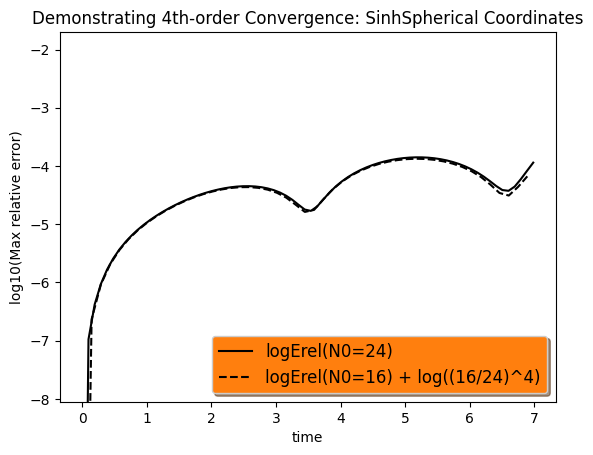

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpmath as mp
import csv

def file_reader(filename):
    with open(filename) as file:
        reader = csv.reader(file, delimiter=" ")
        data  = list(zip(*reader))
        # data is a tuple of strings. Tuples are immutable, and we need to perform math on
        #   the data, so here we convert tuple to lists of floats:
        data0 = []
        data1 = []
        for i in range(len(data[0])):
            data0.append(float(data[0][i]))
            data1.append(float(data[1][i]))
        return data0,data1

first_col16,second_col16 = file_reader(os.path.join(outdir, 'out-lowresolution.txt'))
first_col24,second_col24 = file_reader(os.path.join(outdir, 'out-medresolution.txt'))

second_col16_rescaled4o = []
second_col16_rescaled5o = []
for i in range(len(second_col16)):
    # data16 = data24*(16/24)**4
    # -> log10(data24) = log10(data24) + 4*log10(16/24)
    second_col16_rescaled4o.append(second_col16[i] + 4*mp.log10(16./24.))
    second_col16_rescaled5o.append(second_col16[i] + 5*mp.log10(16./24.))

# https://matplotlib.org/gallery/text_labels_and_annotations/legend.html#sphx-glr-gallery-text-labels-and-annotations-legend-py
fig, ax = plt.subplots()

plt.title("Demonstrating 4th-order Convergence: "+par.parval_from_str("reference_metric::CoordSystem")+" Coordinates")
plt.xlabel("time")
plt.ylabel("log10(Max relative error)")

ax.plot(first_col24, second_col24, 'k-', label='logErel(N0=24)')
ax.plot(first_col16, second_col16_rescaled4o, 'k--', label='logErel(N0=16) + log((16/24)^4)')
ax.set_ylim([-8.05, -1.7]) # Manually set the y-axis range case, since the log10
                          # relative error at t=0 could be -inf or about -16,
                          # resulting in very different-looking plots
                          # despite the data being the same to roundoff.
if par.parval_from_str("reference_metric::CoordSystem") == "Cartesian":
    ax.set_ylim([-2.68, -1.62])
if par.parval_from_str("reference_metric::CoordSystem") == "Cylindrical":
    ax.plot(first_col16, second_col16_rescaled5o, 'k.',  label='(Assuming 5th-order convergence)')
legend = ax.legend(loc='lower right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('C1')
plt.show()

<a id='latex_pdf_output'></a>

# Step 5: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-ScalarWaveCurvilinear.pdf](Tutorial-Start_to_Finish-ScalarWaveCurvilinear.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [15]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-ScalarWaveCurvilinear")

Created Tutorial-Start_to_Finish-ScalarWaveCurvilinear.tex, and compiled
    LaTeX file to PDF file Tutorial-Start_to_Finish-
    ScalarWaveCurvilinear.pdf
